In [2]:
import sys
sys.path.append("../..")
sys.path.append("../../sac_ae")

In [3]:
import torch
import numpy as np
from IPython import display
from ipywidgets import Output, GridspecLayout
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
import pandas as pd

In [3]:
from sac_ae.env import make_envs
from sac_ae.model import make_model
from sac_ae.agent import make_agent
from utils.misc import eval_mode, VideoRecorder
from utils.argument import Arguments

In [4]:
def load_agent_and_args(path, device=torch.device('cpu'), model_name='model/best_model.pt', cost_samples=None, cost_allowed_threshold=None):
    args = Arguments(path + 'args.json')
    weights = torch.load(path + model_name, map_location=device)
    
    if cost_samples != None:
        args.cost_samples = cost_samples
    if cost_allowed_threshold != None:
        args.cost_allowed_threshold = cost_allowed_threshold
    print(f'n: {args.cost_samples}, delta: {args.cost_allowed_threshold}')
    if args.agent == 'sac_state':
        agent_obs_shape = weights['actor.encoder.projection.projection.0.weight'].shape[1:]
        args.agent_image_size = agent_obs_shape[0]
    else:
        agent_obs_shape = (3*args.frame_stack, args.agent_image_size, args.agent_image_size)
    action_shape = np.array([4])

    model = make_model(agent_obs_shape, action_shape, args, device)
    agent = make_agent(model, device, action_shape, args)
    agent.load_model_from_dict(weights)
    return agent, args

In [5]:
def one_episode(agent, args, seed, video_name=None, compute_log_std=False):
    if video_name != None:
        video = VideoRecorder('./ensemble_analysis')

    env = make_envs(args, is_eval=True, use_state=True)
    env.seed(seed)
    obs = env.reset()
    
    if video_name != None:
        video.init()
        video.record(env)

    episode_reward, episode_cost = 0, 0
    actions = np.zeros(shape=(env._max_episode_steps, 4))
    
    log_std_list = np.zeros(shape=(env._max_episode_steps, 4))

    for step in range(env._max_episode_steps):
            with eval_mode(agent):
                action = agent.select_action(obs)
                actions[step] = action
                if compute_log_std:
                    obs_torch = torch.FloatTensor(obs).to(device).unsqueeze(0)
                    mu, pi, log_pi, log_std = agent.model.actor(obs_torch, compute_log_pi=True)
                    log_std_list[step] = log_std.detach().cpu().numpy()

            next_obs, reward, done, info = env.step(action)
            if video_name != None:
                video.record(env)
            episode_reward += reward
            if args.cost != 'no_cost':
                episode_cost += info['cost']

            obs = next_obs
    if video_name != None:
        video.save(video_name)
    print(f'Reward: {np.round(episode_reward, decimals=2)}, Cost: {np.round(episode_cost, decimals=2)}')
    if compute_log_std:
        return log_std_list
    return actions

In [6]:
def calc_success_rate(agent, args, seed, num_episodes=100, stochastic=False, low_cost_action=False):
    env = make_envs(args, is_eval=True, use_state=args.agent == 'sac_state')
    env.seed(seed)
    
    num_successes, reward_sum, cost_sum = 0, 0, 0
    
    for i in range(num_episodes): 
        obs = env.reset()

        episode_reward, episode_cost = 0, 0
        done = False

        while not done:
                with eval_mode(agent):
                    if low_cost_action:
                        action = agent.select_low_cost_action(obs)
                    elif stochastic:
                        action = agent.sample_action(obs)
                    else:
                        action = agent.select_action(obs)

                next_obs, reward, done, info = env.step(action)
                episode_reward += reward
                if args.cost != 'no_cost':
                    episode_cost += info['cost']

                obs = next_obs
        reward_sum += episode_reward
        cost_sum += episode_cost
        success = False
        if info.get('is_success'):
            num_successes += 1
            success = True
    return num_successes / num_episodes, reward_sum / num_episodes, cost_sum / num_episodes

In [11]:
seed = np.random.randint(1000000)
seed

837355

In [7]:
seed = 837355

In [14]:
barrier_results = pd.DataFrame(columns=['algo', 'ensemble_id', 'success_rate', 'mean_reward', 'mean_cost'])
barrier_results['ensemble_id'] = pd.to_numeric(barrier_results['ensemble_id'], downcast='integer')
base_path = '../../../output/final/fetch-push-barrier-final-2/'

for cost in ['reward', 'critic_train', 'critic_eval']:
    for i in range(3):
        path = base_path + f'sac_state_cost-{cost}_{i}/'
        agent, args = load_agent_and_args(path, device=torch.device('cuda'), model_name='model/latest_model.pt')
        success_rate, mean_reward, mean_cost = calc_success_rate(agent, args, seed, 1000, False)
        barrier_results.loc[len(barrier_results)] = [cost, i, success_rate, mean_reward, mean_cost]

In [9]:
safety_eval_results = pd.DataFrame(columns=['algo', 'ensemble_id', 'success_rate', 'mean_reward', 'mean_cost'])
safety_eval_results['ensemble_id'] = pd.to_numeric(safety_eval_results['ensemble_id'], downcast='integer')
base_path = '../../../output/final/fetch-push-barrier-final-2/'
cost = 'critic_eval'

for i in range(3):
    path = base_path + f'sac_state_cost-{cost}_{i}/'
    agent, args = load_agent_and_args(path, device=torch.device('cuda'), model_name='model/latest_model.pt')
    success_rate, mean_reward, mean_cost = calc_success_rate(agent, args, seed, 1000, False, low_cost_action=True)
    safety_eval_results.loc[len(safety_eval_results)] = [cost, i, success_rate, mean_reward, mean_cost]

In [12]:
safety_eval_results.to_pickle('results/push-barrier/eval_data_safety_eval.pkl')

In [15]:
barrier_results.to_pickle('results/push-barrier/eval_data.pkl')

In [13]:
barrier_results = pd.read_pickle('results/push-barrier/eval_data.pkl')

In [20]:
barrier_results

,algo,ensemble_id,success_rate,mean_reward,mean_cost
0,reward,0,0.596,-18.319959,3.925308
1,reward,1,0.677,-15.518541,2.732414
2,reward,2,0.751,-15.559606,2.688569
3,critic_train,0,0.616,-14.008700,1.390776
4,critic_train,1,0.751,-11.794841,2.033867
5,critic_train,2,0.672,-14.029918,1.846155
6,critic_eval,0,0.662,-13.843827,17.753809
7,critic_eval,1,0.602,-14.608688,20.356086
8,critic_eval,2,0.390,-18.678339,25.061640


In [16]:
barrier_results.replace('critic_eval', 'Safety Evaluation n=1', inplace=True)
barrier_results.replace('critic_train', 'Safety Training', inplace=True)
barrier_results.replace('reward', 'Reward Based', inplace=True)

In [28]:
barrier_results

,algo,ensemble_id,success_rate,mean_reward,mean_cost
0,Reward Based,0,0.596,-18.319959,3.925308
1,Reward Based,1,0.677,-15.518541,2.732414
2,Reward Based,2,0.751,-15.559606,2.688569
3,Safety Training,0,0.616,-14.008700,1.390776
4,Safety Training,1,0.751,-11.794841,2.033867
5,Safety Training,2,0.672,-14.029918,1.846155
6,Safety Evaluation,0,0.662,-13.843827,17.753809
7,Safety Evaluation,1,0.602,-14.608688,20.356086
8,Safety Evaluation,2,0.390,-18.678339,25.061640


In [18]:
safety_eval_results.replace('critic_eval', 'Safety Evaluation n=10', inplace=True)

In [22]:
combined = barrier_results.append(safety_eval_results, ignore_index=True).sort_values(by='algo')

In [23]:
grouped = combined.groupby(['algo']).mean()
grouped

,ensemble_id,success_rate,mean_reward,mean_cost
algo,,,,
Reward Based,1.0,0.674667,-16.466035,3.115430
Safety Evaluation,1.0,0.551333,-15.710285,21.057178
Safety Evaluation n=10,1.0,0.584667,-15.231050,16.396370
Safety Training,1.0,0.679667,-13.277820,1.756933


In [24]:
grouped.index = grouped.index.set_names(['Algorithm'])

In [25]:
print(grouped[['success_rate', 'mean_reward', 'mean_cost']].round(3).to_latex(header=['Mean Success Rate', 'Mean Reward', 'Mean Cost']))

\begin{tabular}{lrrr}
\toprule
{} & Mean Success Rate & Mean Reward & Mean Cost \\
Algorithm              &                   &             &           \\
\midrule
Reward Based           &             0.675 &     -16.466 &     3.115 \\
Safety Evaluation      &             0.551 &     -15.710 &    21.057 \\
Safety Evaluation n=10 &             0.585 &     -15.231 &    16.396 \\
Safety Training        &             0.680 &     -13.278 &     1.757 \\
\bottomrule
\end{tabular}



# Safety Evaluation Analysis

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
safety_eval_results = pd.DataFrame(columns=['algo', 'ensemble_id', 'success_rate', 'mean_reward', 'mean_cost', 'n', 'delta'])
safety_eval_results['ensemble_id'] = pd.to_numeric(safety_eval_results['ensemble_id'], downcast='integer')
base_path = '../../../output/final/fetch-push-barrier-final-2/'
cost = 'critic_eval'

for i in range(3):
    path = base_path + f'sac_state_cost-{cost}_{i}/'
    for delta in [0.0, 0.05, 0.1, 0.2, 0.5]:
        for n in [1, 5, 10]:
            agent, args = load_agent_and_args(path, device=torch.device('cuda'), model_name='model/latest_model.pt', cost_samples=n, cost_allowed_threshold=delta)
            success_rate, mean_reward, mean_cost = calc_success_rate(agent, args, seed, 1000, False, low_cost_action=True)
            safety_eval_results.loc[len(safety_eval_results)] = [cost, i, success_rate, mean_reward, mean_cost, n, delta]

n: 1, delta: 0.0
n: 5, delta: 0.0
n: 10, delta: 0.0
n: 1, delta: 0.05
n: 5, delta: 0.05


In [ ]:
safety_eval_results.to_pickle('results/push-barrier/safety_eval.pkl')

In [4]:
safety_eval_results = pd.read_pickle('results/push-barrier/safety_eval.pkl')

In [33]:
cost_samples = []
cost_threshold = []
for i in range(3):
    for delta in [0.0, 0.05, 0.1, 0.2, 0.5]:
        for n in [1, 5, 10]:
            cost_samples.append(n)
            cost_threshold.append(delta)

In [34]:
safety_eval_results['n'] = cost_samples
safety_eval_results['delta'] = cost_threshold

In [9]:
safety_eval_results_2 = pd.DataFrame(columns=['algo', 'ensemble_id', 'success_rate', 'mean_reward', 'mean_cost', 'n', 'delta'])
safety_eval_results_2['ensemble_id'] = pd.to_numeric(safety_eval_results_2['ensemble_id'], downcast='integer')
base_path = '../../../output/final/fetch-push-barrier-final-2/'
cost = 'critic_eval'
n = 2
for i in range(3):
    path = base_path + f'sac_state_cost-{cost}_{i}/'
    for delta in [0.0, 0.05, 0.1, 0.2, 0.5]:
        agent, args = load_agent_and_args(path, device=torch.device('cuda'), model_name='model/latest_model.pt', cost_samples=n, cost_allowed_threshold=delta)
        success_rate, mean_reward, mean_cost = calc_success_rate(agent, args, seed, 1000, False, low_cost_action=True)
        safety_eval_results_2.loc[len(safety_eval_results_2)] = [cost, i, success_rate, mean_reward, mean_cost, n, delta]

n: 2, delta: 0.0
n: 2, delta: 0.05
n: 2, delta: 0.1
n: 2, delta: 0.2
n: 2, delta: 0.5
n: 2, delta: 0.0
n: 2, delta: 0.05
n: 2, delta: 0.1
n: 2, delta: 0.2
n: 2, delta: 0.5
n: 2, delta: 0.0
n: 2, delta: 0.05
n: 2, delta: 0.1
n: 2, delta: 0.2
n: 2, delta: 0.5


In [12]:
safety_eval_results_2.to_pickle('results/push-barrier/safety_eval_2.pkl')

In [35]:
safety_eval_results_2 = pd.read_pickle('results/push-barrier/safety_eval_2.pkl')

In [41]:
safety_grouped = safety_eval_results[(safety_eval_results['n'] != 1) | (safety_eval_results['delta']==0)].append(safety_eval_results_2, ignore_index=True).sort_values(by=['n', 'delta']).groupby(['n','delta']).mean()
safety_grouped

ensemble_id  success_rate  mean_reward  mean_cost
n  delta                                                   
1  0.00           1.0      0.550333   -15.607671  21.177457
2  0.00           1.0      0.579000   -15.460329  19.088855
   0.05           1.0      0.569667   -15.280445  19.756040
   0.10           1.0      0.579000   -15.328872  19.587734
   0.20           1.0      0.569667   -15.003603  19.510350
   0.50           1.0      0.570333   -15.065318  20.797228
5  0.00           1.0      0.592333   -15.125411  17.885958
   0.05           1.0      0.580667   -15.272712  17.023745
   0.10           1.0      0.581667   -15.381751  16.938981
   0.20           1.0      0.585667   -15.174154  17.564247
   0.50           1.0      0.588667   -15.014129  18.023440
10 0.00           1.0      0.574667   -15.531000  16.647310
   0.05           1.0      0.575667   -15.497510  16.069242
   0.10           1.0      0.591667   -15.038114  16.258799
   0.20           1.0      0.595667   -15.132406  16.197968
   0.50           1.0      0.581000   -15.263676  16.463910

In [42]:
print(safety_grouped[['success_rate', 'mean_reward', 'mean_cost']].round(3).to_latex(header=['Mean Success Rate', 'Mean Reward', 'Mean Cost'], multirow=True))

\begin{tabular}{llrrr}
\toprule
   &      & Mean Success Rate & Mean Reward & Mean Cost \\
n & delta &                   &             &           \\
\midrule
1  & 0.00 &             0.550 &     -15.608 &    21.177 \\
\multirow{5}{*}{2} & 0.00 &             0.579 &     -15.460 &    19.089 \\
   & 0.05 &             0.570 &     -15.280 &    19.756 \\
   & 0.10 &             0.579 &     -15.329 &    19.588 \\
   & 0.20 &             0.570 &     -15.004 &    19.510 \\
   & 0.50 &             0.570 &     -15.065 &    20.797 \\
\cline{1-5}
\multirow{5}{*}{5} & 0.00 &             0.592 &     -15.125 &    17.886 \\
   & 0.05 &             0.581 &     -15.273 &    17.024 \\
   & 0.10 &             0.582 &     -15.382 &    16.939 \\
   & 0.20 &             0.586 &     -15.174 &    17.564 \\
   & 0.50 &             0.589 &     -15.014 &    18.023 \\
\cline{1-5}
\multirow{5}{*}{10} & 0.00 &             0.575 &     -15.531 &    16.647 \\
   & 0.05 &             0.576 &     -15.498 &    16.069 \\
 

In [43]:
safety_grouped.reset_index(inplace=True)
safety_grouped['delta'] = pd.Categorical(safety_grouped['delta'].map(lambda x : f'{x}'), ordered=True)
safety_grouped['n'] = pd.Categorical(safety_grouped['n'].map(lambda x : f' {x} ' if x!=10 else f'{x}'), ordered=True)

In [44]:
sns.set_context("notebook")
sns.set(style='whitegrid', font_scale=2)

In [45]:
color_palette = 'flare'

In [46]:
color = sns.color_palette('muted')[0]

In [47]:
safety_grouped

,n,delta,ensemble_id,success_rate,mean_reward,mean_cost
0,1,0.0,1.0,0.550333,-15.607671,21.177457
1,2,0.0,1.0,0.579000,-15.460329,19.088855
2,2,0.05,1.0,0.569667,-15.280445,19.756040
3,2,0.1,1.0,0.579000,-15.328872,19.587734
4,2,0.2,1.0,0.569667,-15.003603,19.510350
5,2,0.5,1.0,0.570333,-15.065318,20.797228
6,5,0.0,1.0,0.592333,-15.125411,17.885958
7,5,0.05,1.0,0.580667,-15.272712,17.023745
8,5,0.1,1.0,0.581667,-15.381751,16.938981
9,5,0.2,1.0,0.585667,-15.174154,17.564247


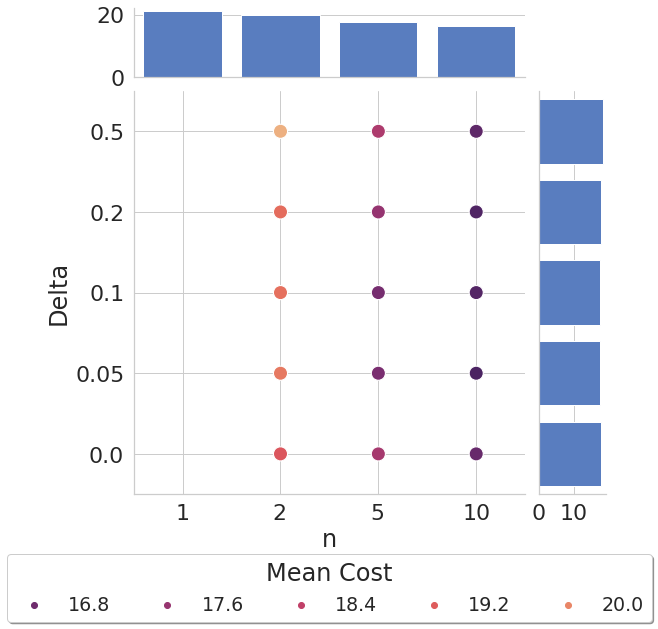

In [51]:
g = sns.JointGrid(marginal_ticks=True, height=8)
sns.scatterplot(data=safety_grouped[safety_grouped['n'] != ' 1 '], x='n', y='delta', hue='mean_cost', palette=color_palette+'_r', s=200, ax=g.ax_joint)
sns.barplot(data=safety_grouped, x='n', y='mean_cost', ci=None, color=color, ax=g.ax_marg_x)
sns.barplot(data=safety_grouped[safety_grouped['n'] != ' 1 '], x='mean_cost', y='delta', orient='h', ci=None, color=color, ax=g.ax_marg_y)
g.ax_joint.set_ylabel('Delta')

g.ax_joint.invert_yaxis()

g.ax_joint.legend(loc='lower center', 
               bbox_to_anchor=(0.5, -0.34), 
               fancybox=True, 
               shadow=True, 
               ncol=5, 
               prop={'size': 19},
               title='Mean Cost')
g.savefig('results/push-barrier/safety_eval_cost.png', bbox_inches='tight')

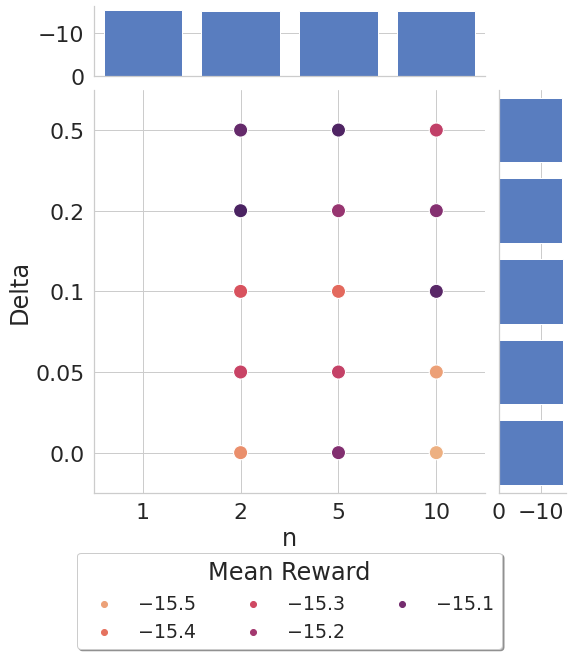

In [52]:
g = sns.JointGrid(marginal_ticks=True, height=8)
sns.scatterplot(data=safety_grouped[safety_grouped['n'] != ' 1 '], x='n', y='delta', hue='mean_reward', palette=color_palette, s=200, ax=g.ax_joint)
sns.barplot(data=safety_grouped, x='n', y='mean_reward', ci=None, color=color, ax=g.ax_marg_x)
sns.barplot(data=safety_grouped[safety_grouped['n'] != ' 1 '], x='mean_reward', y='delta', orient='h', ci=None, color=color, ax=g.ax_marg_y)
g.ax_joint.set_ylabel('Delta')

g.ax_joint.invert_yaxis()
g.ax_marg_x.invert_yaxis()
g.ax_marg_y.invert_xaxis()

g.ax_joint.legend(loc='lower center', 
               bbox_to_anchor=(0.5, -0.41), 
               fancybox=True, 
               shadow=True, 
               ncol=3, 
               prop={'size': 19},
               title='Mean Reward')
g.savefig('results/push-barrier/safety_eval_reward.png', bbox_inches='tight')

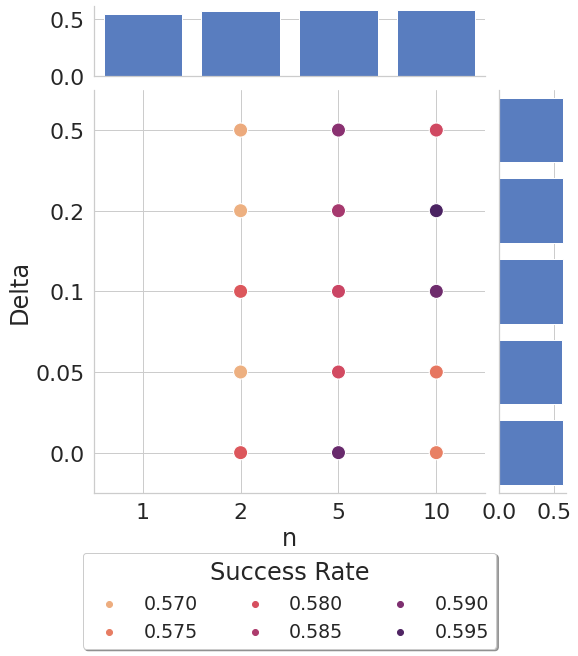

In [53]:
g = sns.JointGrid(marginal_ticks=True, height=8)
sns.scatterplot(data=safety_grouped[safety_grouped['n'] != ' 1 '], x='n', y='delta', hue='success_rate', palette=color_palette, s=200, ax=g.ax_joint)
sns.barplot(data=safety_grouped, x='n', y='success_rate', ci=None, color=color, ax=g.ax_marg_x)
sns.barplot(data=safety_grouped[safety_grouped['n'] != ' 1 '], x='success_rate', y='delta', orient='h', ci=None, color=color, ax=g.ax_marg_y)
g.ax_joint.set_ylabel('Delta')

g.ax_joint.invert_yaxis()

g.ax_joint.legend(loc='lower center', 
               bbox_to_anchor=(0.5, -0.41), 
               fancybox=True, 
               shadow=True, 
               ncol=3, 
               prop={'size': 19},
               title='Success Rate')
g.savefig('results/push-barrier/safety_eval_success.png', bbox_inches='tight')